$$
\newcommand{\hprob}{H_P}
\newcommand{\hmix}{H_{\mathrm{0}}}
\newcommand{\hinit}{H_{\mathrm{init}}}
\newcommand{\ket}[1]{| #1 \rangle}
\newcommand{\bra}[1]{\langle #1 |}
$$

## Demo notebook

In the following I briefly present reverse annealing in the context of the $p$-spin model and then use the same model to demonstrate the ideas of adiabatic spectroscopy, introduced by [Schiffer et al.](https://doi.org/10.1103/PRXQuantum.3.020347)

### Reverse annealing in the $p$-spin model

Adiabatic reverse annealing (ARA) is a variant of the adiabatic algorithm, where the evolution is initialized with an approximation of the ground state of $\hprob$ which can be efficiently computed by other means. This initial guess is encoded as the ground state of $\hinit$ and the total Hamiltonian is then defined as:

$$
H\left(s(t), \lambda(t)\right)
=
(1-s(t))(1-\lambda(t))\hinit
+
(1-s(t))\lambda(t)\hmix
+
s(t)\lambda(t)\hprob,
$$

with the boundary conditions $s(0)=\lambda(0)=0$ and $s(T)=\lambda(T)=1$. We use

$$\hprob
=
-N\left(
\frac{1}{N}\sum_{i=1}^{N}\sigma_i^z
\right)^p
\quad\text{and}\quad
\hmix 
=
\sum_{i=1}^N
\sigma_i^x
$$

with $p=3$ as the problem Hamiltonian, with $N$ the number of sites and $\sigma_i^z$ the Pauli $z$ matrix operating on $i$-th site.
The unique ground state for odd $p$ of $H_P$ is $\ket{0}^{\otimes N}$ -- we then consider different initial guesses, where the quality $c$ of the initial approximation corresponds to the ratio of qubits in the initial state which are in the correct state $\ket{0}$:
$$
\hinit(c)
=
-\sum_{i=1}^N
\epsilon_i \sigma_i^z,
\quad
\epsilon_i 
=
\begin{cases}
+1~\mathrm{if}~i\leq N c,\\
-1~\mathrm{else}.
\end{cases}.
$$
The ground state of $H(0,0)=\hinit(c)$ is then
$$
\ket{\psi_{\mathrm{init}}} 
=
\left(\ket{0}^{\otimes Nc}\right)
\otimes
\left(\ket{1}^{\otimes N(1-c)}\right),
$$
assuming that $Nc$ is an integer. A useful feature of the problem defined in this manner is that the total spin $\mathbf{\hat{S}}_{1,2}^2$ is a conserved quantity in each of the sectors (i.e. for $i\leq Nc$ or $i>Nc$). Thus the dimension of the Hilbert space that we analyze is $(2Nc+1)(2N(1-c) + 1)$, which is $\mathcal{O}\left(N^2\right)$. Hence, larger system sizes are accessible in numerical simulations.

Let us first define the required operators. The implementation here is based on [QuTip](https://qutip.org/), with the accompanying code found in ara.py.

In [1]:
# load the module

%load_ext autoreload
%autoreload 2

from ara import *

In [2]:
# nr of qubits
n = 15

# initial guess hamiltonian:
c = 0.8
hinit = h_init(n, c)


# define p-spin and transverse field hamiltonians
hfinal = pspin(n, c)
h0 = v_tf(n, c)


print(f'Hilbert space dimension: {np.prod(hinit.dims[0])}')

Hilbert space dimension: 175


#### Phase transition of $H(s,\lambda; c)$

In the thermodynamic limit one can exactly obtain the free energy of $H(s,\lambda; c)$ (see [2]). One can then maximize the free energy and obtain a self-consistency for the magnetization ($m=\langle \sum_i \sigma_z^i$). Here we compute the phase diagram obtained in this manner for different $c$ values.

In [3]:
%%capture

# resolution of phase diagram
resolution = 100
# s & lambda domain
ss = np.linspace(1e-5, 1.-1e-5, resolution)
lambs = np.linspace(0.0, 1, resolution)

# storing results:
container = {}
for c in [0.7, 0.8, 0.9]:
    ms = []
    # iterate over s, lambda
    for l in lambs:
        for s in ss:
            ms.append(get_magnetization(l, s, c))
    # reshape for visualization
    ms = np.reshape(ms, (resolution, resolution)).T[::-1]
    # store
    container[c] = ms

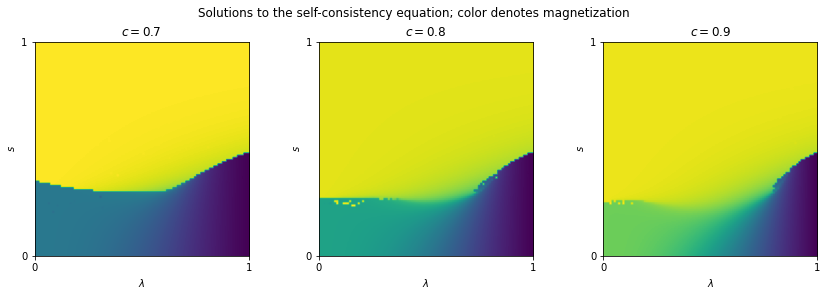

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

for i, c in enumerate(container.keys()):
    ms = container[c]
    axs[i].imshow(ms, cmap='viridis',
                extent=(min(lambs),max(lambs), min(ss),max(ss)),
    #             extent=(0,1,0,1),
                aspect=1)
    # plt.colorbar()

    axs[i].set_xticks(np.linspace(0,1,2))
    axs[i].set_yticks(np.linspace(0,1,2))

    axs[i].set_xlabel(r'$\lambda$')
    axs[i].set_ylabel(r'$s$')
    axs[i].set_title(f'$c={c}$')
    
    axs[i].set_ylim(0,1)


plt.suptitle('Solutions to the self-consistency equation; color denotes magnetization')
plt.tight_layout()
plt.show()


Clearly, the phase transition happens in a lesser part of the phase space as $c$ is increased. It is typically the case that a first order phase transition is accompanyed by an exponentially closing gap for finite $N$. Let us thus compute the spectral gap $\Delta = E_1 - E_0$ explicitly and map out an analogous phase diagram:

In [5]:
%%time

resolution = 40

ss = np.linspace(0, 1, resolution)
lambs = np.linspace(0.0, 1, resolution)

    
res = {}
for c in [0.7, 0.8, 0.9]:
    gaps = []
    for l in lambs:
        for s in ss:
            # compute the eigenvalue gap. h_ara is H(s, lambda; c), with p=3
            gaps.append(np.diff(np.linalg.eigvalsh(h_ara(l, s, n, c)))[0])
    gaps = np.reshape(gaps, (resolution, resolution)).T[::-1]
    print(f"{c} completed.")
    res[c] = gaps
print('\n')

0.7 completed.
0.8 completed.
0.9 completed.


CPU times: user 4min 57s, sys: 8.33 s, total: 5min 5s
Wall time: 52.3 s


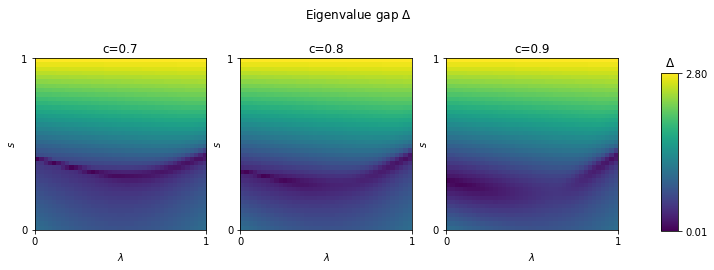

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

min_gap, max_gap = np.min([a for a in res.values()]), np.max([a for a in res.values()])


for i, c in enumerate(res.keys()):
    gaps = res[c]
    msh = axs[i].imshow(gaps, cmap='viridis',
                extent=(min(lambs), max(lambs), min(ss), max(ss)),
                aspect=1, vmin=min_gap, vmax=max_gap)

    axs[i].set_xticks(np.linspace(0,1,2))
    axs[i].set_yticks(np.linspace(0,1,2))

    axs[i].set_xlabel(r'$\lambda$')
    axs[i].set_ylabel(r'$s$')
    axs[i].set_title(f'c={c}')
    axs[i].set_ylim(0,1)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.55])
cb = fig.colorbar(msh, cax=cbar_ax, fraction=0.1)
cb.ax.set_title('$\Delta$')
cb.ax.set_yticks(np.round([min_gap, max_gap], 2))

fig.suptitle('Eigenvalue gap $\Delta$')
plt.show()
    

As expected, the eigenvalue gap structure matches the thermodynamic limit behaviour quite nicely, with a larger $c$ value corresponding to a path in $(\lambda, s)$ plane which can will have a larger minimal eigenvalue gap. Thus, if one could navigate this landscape cleverly, a smaller total time would be required to reach the desired fidelity.

### Adiabatic spectroscopy

To this end, let us introduce adiabatic spectroscopy as a means to navigate this landscape. In [1] the authors introduce protocols that allow us to compute the ground state overlap using a quantum computer. Let us first quickly demonstrate how that can be useful in a toy example, here in a regular adiabatic setting without the $\hinit$ term.

Let's assume that we can compute the overlap by some means -- what can this tell us about the energy gap between the ground state and the first excited state?

(**Note:** everything to do with adiabatic evolution is performed using the AdiabaticEvolution class, which you can find the accompanying ara.py file)

In [7]:
# instantiate an AdiabaticEvolution class instance.
T = 20
ae = AdiabaticEvolution(problem=hfinal, mixer=h0, n_chunks=20, T_init=T, interpolation='linear')

In [8]:
# computing the gap via eigenvalue calculation:
resolution = 300
gaps = ae.get_gaps(resolution)
s_list = np.linspace(0, 1, resolution)

# computing the overlap:
overlap_s_list = np.array(ae.schedule)/T


# set number of steps for ode-solver:
ae.step_density = 2
overlaps = [ae.get_overlap(s) for s in overlap_s_list]

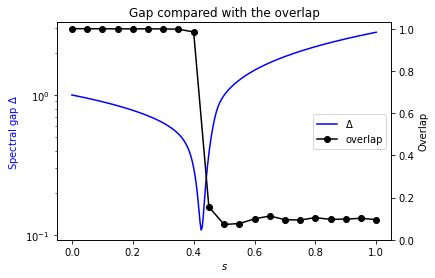

In [9]:
fig, ax = plt.subplots()

ax_r = ax.twinx()

ln1 = ax.plot(s_list, gaps, label=r'$\Delta$', color='b')
ax.set_yscale('log')
ax.set_ylabel(r'Spectral gap $\Delta$', color='b')
ax.set_xlabel(r'$s$')

ln2 = ax_r.plot(overlap_s_list, overlaps, 'ko-', label='overlap')
ax_r.set_ylabel('Overlap')

ax.set_title('Gap compared with the overlap')
ax_r.set_ylim(0, 1.03)

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')

plt.show()

As expected from the statement of the adiabatic theorem, the overlap depends sensitively on the spectral gap. After the region where $\Delta$ gets smaller, the overlap decreases due to diabatic transitions from the ground state into excited states. At the same time, the ground state overlap is actually the quantity we care about in a ground state preparation setting; thus it is enough to use the ground state overlap as a probe when designing adiabatic schedules.

Let us thus quickly demonstrate that the three protocols to estimate the ground state overlap presented in [1] and summarized in the appendix of the exposé.

In [10]:
%%time

# Set the number of chunks at which to probe
ae.chunks = [20] * 5
ae.interpolation = 'linear'

# ODE solver stepsize
ae.step_density = 1
# set the number of shots and tau_interval for the ancilla protocols
n_shots = 20
tau_interval = (1e-1, 100) 


s_list_o = np.linspace(0, 1, ae.n_chunks + 1)[1:]

exact_overlaps = []
forwback_overlaps = []
single_ancilla = []
entangled_ancillae = []


for s in s_list_o:
    exact_overlaps.append(ae.get_overlap(s))
    forwback_overlaps.append(ae.get_overlap_reverse(s, ae.schedule[-1] * 30))
    single_ancilla.append(ae.get_overlap_ancilla(s, n_shots=n_shots, tau_interval=tau_interval, use_esq=True))
    entangled_ancillae.append(ae.get_overlap_entangled(s, n_shots=n_shots, tau_interval=tau_interval, use_esq=True))
    print(f's = {s:.2f} done.')

s = 0.20 done.
s = 0.40 done.
s = 0.60 done.
s = 0.80 done.
s = 1.00 done.
CPU times: user 4min 8s, sys: 2.39 s, total: 4min 11s
Wall time: 4min 15s


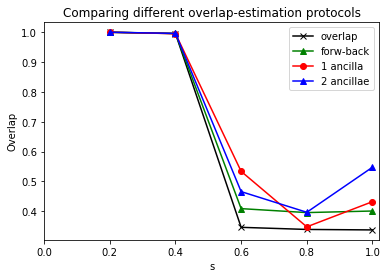

In [11]:
fig, ax = plt.subplots()


ax.plot(s_list_o, exact_overlaps, 'kx-', label=r'overlap')
ax.plot(s_list_o, forwback_overlaps, 'g^-', label='forw-back')
ax.plot(s_list_o, single_ancilla, 'ro-',label='1 ancilla')
ax.plot(s_list_o, entangled_ancillae, 'b^-', label='2 ancillae')


ax.set_xlabel('s')
ax.set_xlim(0, 1.02)

ax.set_ylabel('Overlap')

ax.legend(loc='best')

ax.set_title('Comparing different overlap-estimation protocols')
plt.show()

# fig.savefig('overlaps.pdf', dpi=400, bbox_inches='tight')

### References

[1] Benjamin F. Schiffer, Jordi Tura, and J. Ignacio Cirac. “Adiabatic Spectroscopy and a Varia-
tional Quantum Adiabatic Algorithm”. In: arXiv:2103.01226 [quant-ph] (2021). arXiv: 2103.01226.

[2] Yu Yamashiro et al. “Dynamics of reverse annealing for the fully connected p -spin model”.
en. In: Physical Review A 100.5 (2019), p. 052321. issn: 2469-9926, 2469-9934. doi: 10.1103/
PhysRevA.100.052321.